In [232]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Load your data
SFH_data = np.load('Latent data/SFHdata.npy')
labels_data = np.load('Latent data/labels_vectors.npy')
mass_sfr = np.load('Latent data/masspresentsfr.npy')

# Step 1: Split the data into train, validation, and test sets
SFH_train_val, SFH_test, labels_train_val, labels_test, mass_sfr_train_val, mass_sfr_test = train_test_split(
    SFH_data, labels_data, mass_sfr, test_size=0.2, random_state=42)

SFH_train, SFH_val, labels_train, labels_val, mass_sfr_train, mass_sfr_val = train_test_split(
    SFH_train_val, labels_train_val, mass_sfr_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 validation

# Step 2: Convert the data splits to tensors
SFH_train_tensor = torch.tensor(SFH_train, dtype=torch.float32)
SFH_val_tensor = torch.tensor(SFH_val, dtype=torch.float32)
SFH_test_tensor = torch.tensor(SFH_test, dtype=torch.float32)

labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.float32)

mass_sfr_train_tensor = torch.tensor(mass_sfr_train, dtype=torch.float32)
mass_sfr_val_tensor = torch.tensor(mass_sfr_val, dtype=torch.float32)
mass_sfr_test_tensor = torch.tensor(mass_sfr_test, dtype=torch.float32)

# Step 3: Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(SFH_train_tensor, labels_train_tensor, mass_sfr_train_tensor)
val_dataset = TensorDataset(SFH_val_tensor, labels_val_tensor, mass_sfr_val_tensor)
test_dataset = TensorDataset(SFH_test_tensor, labels_test_tensor, mass_sfr_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)


In [233]:
device = torch.device("mps")

In [234]:
# Building an MLP model
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(16 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)  # Latent space
        
        # Decoder (Pathway 1)
        self.fc4 = nn.Linear(16, 32)
        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 16 * 7)
        self.deconv1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=4, stride=2)
        self.deconv3 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=3, stride=2)
        self.deconv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=2)

        # Pathway 2: MLP for simulation type classification
        self.fc_sim1 = nn.Linear(16, 100)
        self.fc_sim2 = nn.Linear(100, 100)
        self.fc_sim3 = nn.Linear(100, 10)
        
        # Pathway 3: MLP for SM and SFR prediction
        self.fc_sfr1 = nn.Linear(16, 200)
        self.fc_sfr2 = nn.Linear(200, 200)
        self.fc_sfr3 = nn.Linear(200, 200) 
        self.fc_sfr4 = nn.Linear(200, 2)  # Predicting SM and SFR

    def encoder(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 16 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = self.fc3(x)
        return encoded

    def decoder(self, x):
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = x.view(-1, 16, 7)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.relu(self.deconv3(x))
        x = torch.relu(self.deconv4(x))
        return x

    def sim_type_classifier(self, x):
        x = torch.relu(self.fc_sim1(x))
        x = torch.relu(self.fc_sim2(x))
        sim_type_output = self.fc_sim3(x)
        return sim_type_output

    def sfr_predictor(self, x):
        x = torch.relu(self.fc_sfr1(x))
        x = torch.relu(self.fc_sfr2(x))
        x = torch.relu(self.fc_sfr3(x))
        sfr_output = self.fc_sfr4(x)
        return sfr_output
    
    def forward(self, x):
        latent = self.encoder(x)
        
        # Pathway 1: Reconstruct SFH
        sfh_output = self.decoder(latent)
        
        # Pathway 2: Classify sim type
        sim_type_output = self.sim_type_classifier(latent)
        
        # Pathway 3: Predict SM and SFR
        sfr_output = self.sfr_predictor(latent)
        
        return sfh_output, sim_type_output, sfr_output


def compute_loss(sfh_output, sfh_target, sim_type_output, sim_type_target, mass_sfr_output, mass_sfr_target, w_reg, w_cl):
    mse_loss = nn.MSELoss()
    cross_entropy_loss = nn.CrossEntropyLoss()

    loss_sfh = mse_loss(sfh_output, sfh_target)
    loss_sim_type = cross_entropy_loss(sim_type_output, sim_type_target)
    loss_mass_sfr = mse_loss(mass_sfr_output, mass_sfr_target)

    total_loss = loss_sfh + w_reg * loss_mass_sfr + w_cl * loss_sim_type
    # print(f'Loss: {total_loss:.3f} | SFH Loss: {loss_sfh:.3f} | Sim Type Loss: {loss_sim_type:.3f} | Mass-SFR Loss: {loss_mass_sfr:.3f}')
    return total_loss, loss_sfh, loss_sim_type, loss_mass_sfr

AE = ConvAutoencoder().to(device)
optimizer = optim.Adam(AE.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

In [235]:
num_epochs = 800
losses = [] # To store training losses
losses_sfh = []  # To store SFH losses
losses_sim_type = []  # To store sim type losses
losses_mass_sfr = []  # To store mass-sfr losses
val_losses = []  # To store validation losses


for epoch in range(num_epochs):
    total_loss = 0.0
    for data in train_loader:
        inputs, sim_labels, mass_sfr = data
        optimizer.zero_grad()
        inputs = inputs.to(device)
        sim_labels = sim_labels.to(device)
        mass_sfr = mass_sfr.to(device)
        sfh_output, sim_type_output, mass_sfr_output = AE(inputs.unsqueeze(1))
        sfh_output = sfh_output.squeeze(1)
        loss = compute_loss(sfh_output, inputs, sim_type_output, sim_labels, mass_sfr_output, mass_sfr, 1, 1)
        loss = loss[0]
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    total_loss /= len(train_loader)
    losses.append(total_loss)
    
    # Validation phase
    AE.eval()
    val_loss = 0.0
    sfh_loss = 0.0
    sim_type_loss = 0.0
    mass_sfr_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, sim_labels, mass_sfr = data
            inputs = inputs.to(device)
            sim_labels = sim_labels.to(device)
            mass_sfr = mass_sfr.to(device)
            sfh_output, sim_type_output, mass_sfr_output = AE(inputs.unsqueeze(1))
            loss, loss_sfh, loss_sim_type, loss_mass_sfr = compute_loss(sfh_output, inputs, sim_type_output, sim_labels, mass_sfr_output, mass_sfr, 1, 1)
            val_loss += loss.item()
            sfh_loss += loss_sfh.item()
            sim_type_loss += loss_sim_type.item()
            mass_sfr_loss += loss_mass_sfr.item()
            
    
    val_loss /= len(val_loader)
    sfh_loss /= len(val_loader)
    sim_type_loss /= len(val_loader)
    mass_sfr_loss /= len(val_loader)
    val_losses.append(val_loss)
    losses_sfh.append(sfh_loss)
    losses_sim_type.append(sim_type_loss)
    losses_mass_sfr.append(mass_sfr_loss)
    
    print(f'Epoch [{epoch}/{num_epochs}], Training Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, SFH Loss: {sfh_loss:.4f}, Sim Type Loss: {sim_type_loss:.4f}, Mass-SFR Loss: {mass_sfr_loss:.4f}')
    
    scheduler.step()

print('Training complete')

Epoch [0/800], Training Loss: 13.6686, Val Loss: 10.2097, SFH Loss: 8.0423, Sim Type Loss: 1.7376, Mass-SFR Loss: 0.4298
Epoch [1/800], Training Loss: 8.3416, Val Loss: 13.2772, SFH Loss: 11.4394, Sim Type Loss: 1.4438, Mass-SFR Loss: 0.3940
Epoch [2/800], Training Loss: 5.2410, Val Loss: 13.5386, SFH Loss: 11.9451, Sim Type Loss: 1.2242, Mass-SFR Loss: 0.3694
Epoch [3/800], Training Loss: 4.6136, Val Loss: 14.3244, SFH Loss: 12.5777, Sim Type Loss: 1.3544, Mass-SFR Loss: 0.3924
Epoch [4/800], Training Loss: 4.1644, Val Loss: 13.9035, SFH Loss: 12.7384, Sim Type Loss: 0.8163, Mass-SFR Loss: 0.3488
Epoch [5/800], Training Loss: 3.8485, Val Loss: 14.2275, SFH Loss: 13.3261, Sim Type Loss: 0.6618, Mass-SFR Loss: 0.2396
Epoch [6/800], Training Loss: 3.5817, Val Loss: 14.0061, SFH Loss: 13.0885, Sim Type Loss: 0.6161, Mass-SFR Loss: 0.3015
Epoch [7/800], Training Loss: 3.3800, Val Loss: 13.8092, SFH Loss: 12.9992, Sim Type Loss: 0.5127, Mass-SFR Loss: 0.2973
Epoch [8/800], Training Loss: 3.

KeyboardInterrupt: 

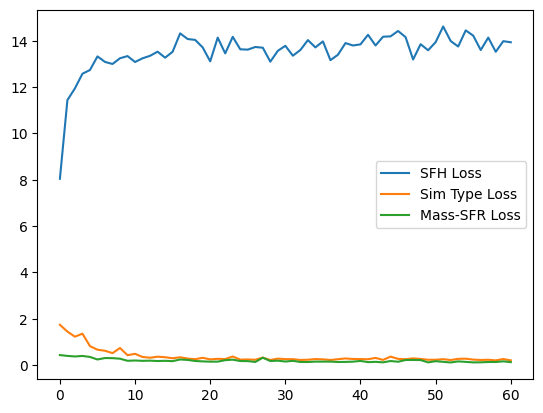

In [237]:
import matplotlib.pyplot as plt
plt.plot(losses_sfh, label='SFH Loss')
plt.plot(losses_sim_type, label='Sim Type Loss')
plt.plot(losses_mass_sfr, label='Mass-SFR Loss')
# show labels
plt.legend()

In [192]:
torch.save(AE, 'AE Models/multimodal.pth')

In [183]:
with torch.no_grad():
    y_pred_tensor = AE(SFH_test_tensor.unsqueeze(1).to(device))

pred_sfh = y_pred_tensor[0]
pred_sim = y_pred_tensor[1]
pred_mass_sfr = y_pred_tensor[2]

In [184]:
pred_mass_sfr.shape, pred_sfh.shape

(torch.Size([12622, 2]), torch.Size([12622, 1, 139]))

In [193]:
stellar_mass = mass_sfr_test_tensor.T[0].to(device)
star_formation_rate = mass_sfr_test_tensor.T[1].to(device)
labels = labels_test_tensor.to(device)

pred_mass = pred_mass_sfr.T[0].to(device)
pred_sfr = pred_mass_sfr.T[1].to(device)

Score for log stellar mass: 0.7324889898300171
Score for arcsinh SFR: 0.5901708602905273

RMSE for Stellar Mass: 0.32540658116340637 
RMSE for SFR: 0.42336007952690125

Baseline RMSE for Stellar Mass: 0.6291518807411194 (Predicting the mean) 
Baseline RMSE for SFR: 0.6613151431083679 (Predicting the mean)

1,5,10,50,90,95,99 Percentiles for mass residuals: [-0.95098936 -0.55100403 -0.39188728 -0.0138154   0.30780087  0.45881624
  0.87230193]

1,5,10,50,90,95,99 Percentiles for SFR residuals: [-1.50476763 -0.75080987 -0.45967154  0.03441979  0.36472343  0.54504322
  1.02261158]


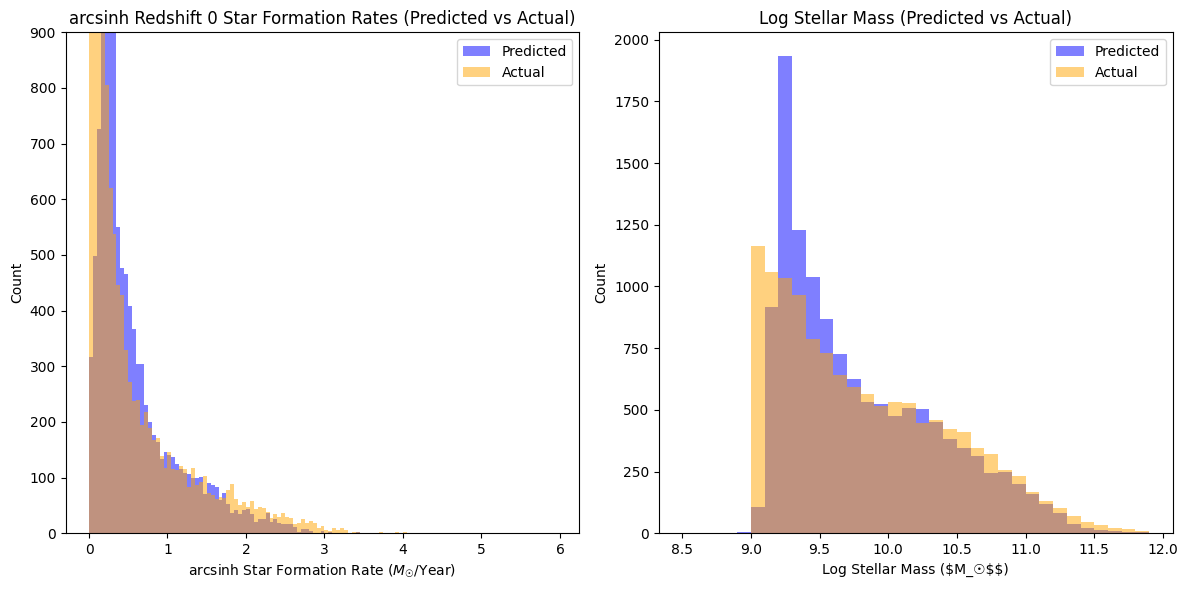

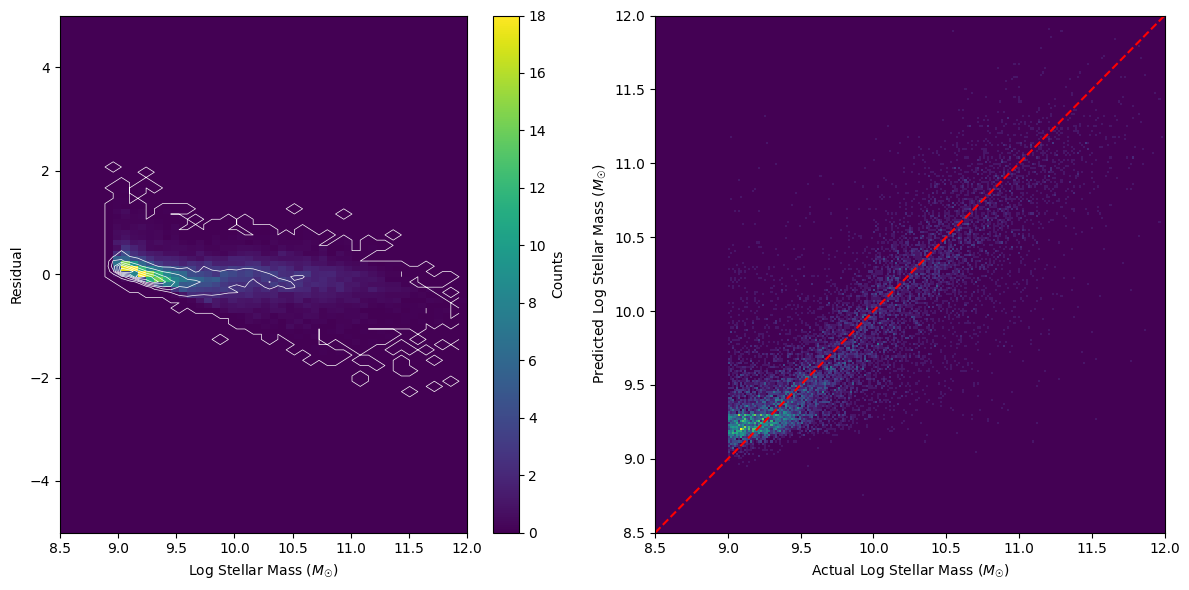

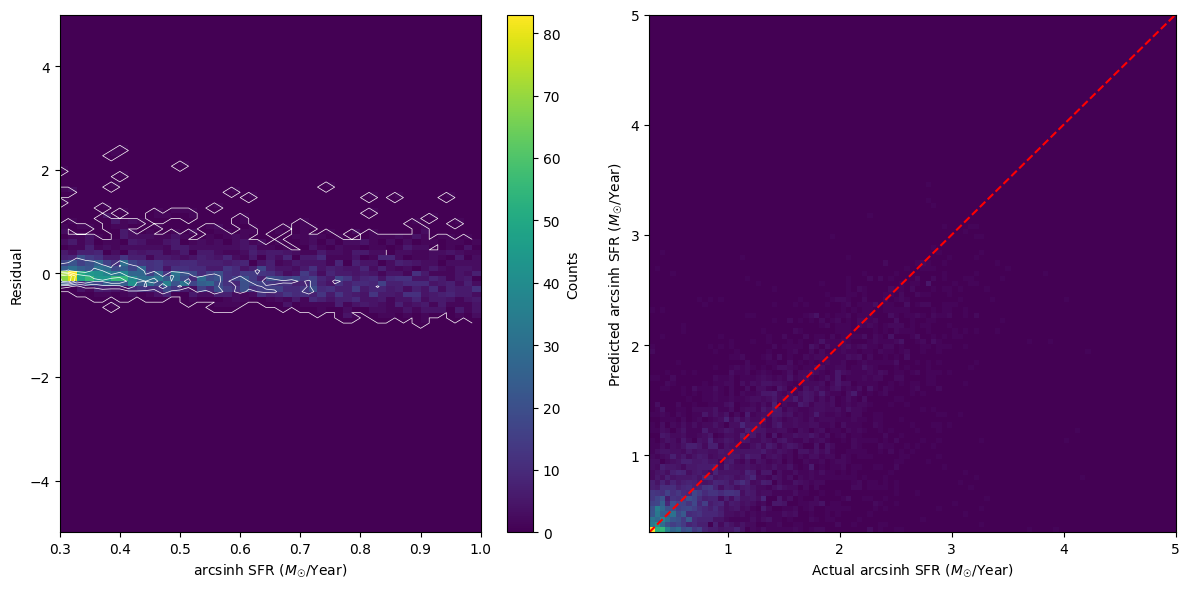

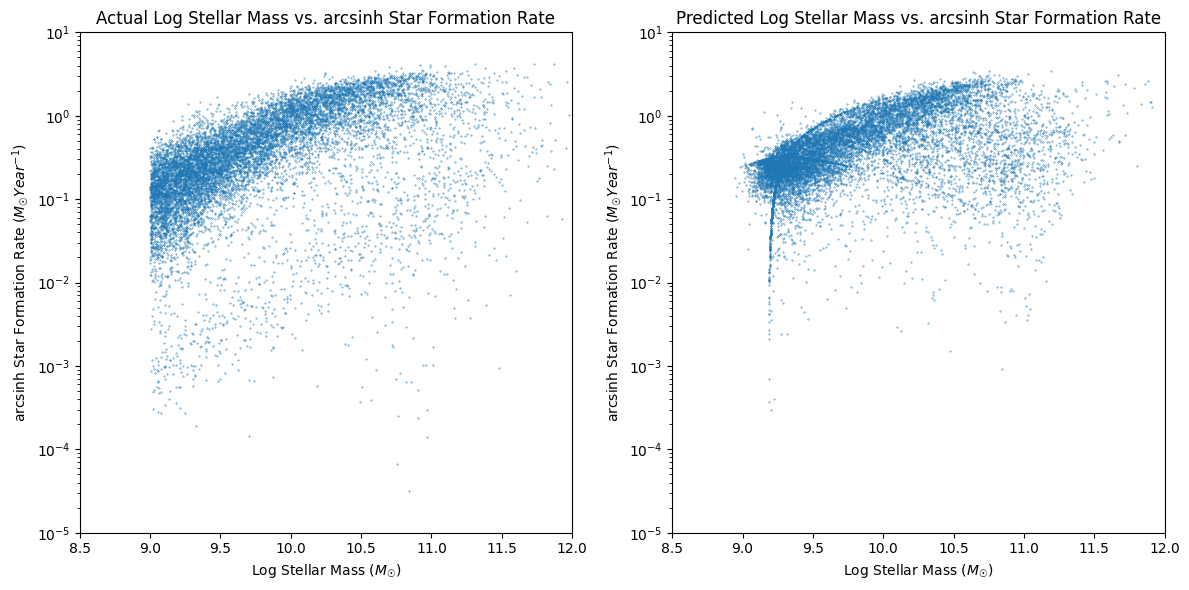

In [191]:
from DataEval import pred_actual_data_eval, pred_actual_data_vis
pred_actual_data_eval(pred_mass.cpu(), pred_sfr.cpu(), stellar_mass.cpu(), star_formation_rate.cpu())
pred_actual_data_vis(pred_mass.cpu(), pred_sfr.cpu(), stellar_mass.cpu(), star_formation_rate.cpu())

In [194]:
test_outputs_categorical = np.zeros(pred_sim.shape)
for i in range(len(pred_sim)):
    _, indices = torch.max(pred_sim[i], 0)    
    predicted_label = indices.item()
    test_outputs_categorical[i][predicted_label] = 1

Text(0.5, 1.0, 'Confusion Matrix: Multi-Modal Autoencoder, 0.94 Accuracy')

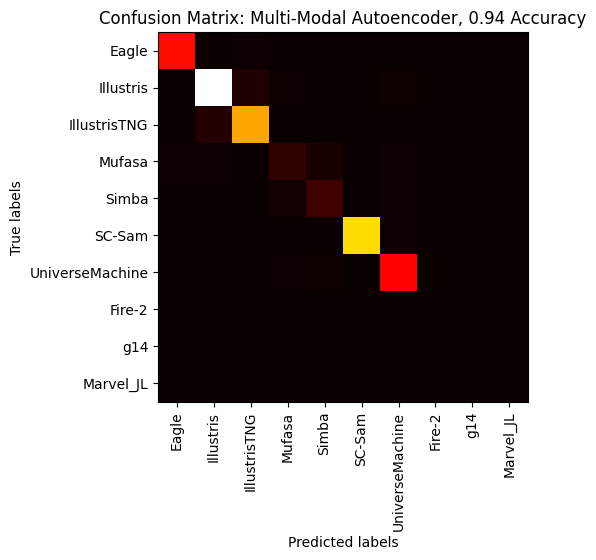

In [207]:
confusion_matrix = np.zeros((10, 10))
for i in range(len(test_outputs_categorical)):
    true_label = torch.argmax(labels[i]).item()
    predicted_label = np.argmax(test_outputs_categorical[i])
    confusion_matrix[true_label][predicted_label] += 1

plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
# Labelling the simulation names

sim_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'g14', 'Marvel_JL']
plt.xticks(np.arange(10), sim_names, rotation=90)
plt.yticks(np.arange(10), sim_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix: Multi-Modal Autoencoder, 0.94 Accuracy')

In [199]:
# Printing the confusion matrix without scientific notation
np.set_printoptions(suppress=True)
print(confusion_matrix)

[[1423.    6.   15.   11.    4.    0.    4.    0.    0.    0.]
 [   3. 3705.  124.   18.    3.    4.   31.    0.    0.    0.]
 [  10.  135. 2273.    7.    2.    0.    3.    0.    0.    0.]
 [  24.   25.    2.  225.   83.    0.   21.    0.    0.    0.]
 [  11.    6.    0.   51.  316.    0.   23.    0.    0.    0.]
 [   0.    3.    2.    0.    0. 2565.   18.    0.    0.    0.]
 [   2.   14.    1.   20.   40.   14. 1366.    0.    0.    0.]
 [   2.    1.    0.    1.    0.    0.    0.    0.    0.    0.]
 [   2.    2.    0.    1.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


In [203]:
# calculate accuracy
correct = 0
for i in range(10):
    correct += confusion_matrix[i][i]
accuracy = correct / np.sum(confusion_matrix)
print(f'Accuracy: {accuracy * 100:.3f}%')

Accuracy: 94.066%


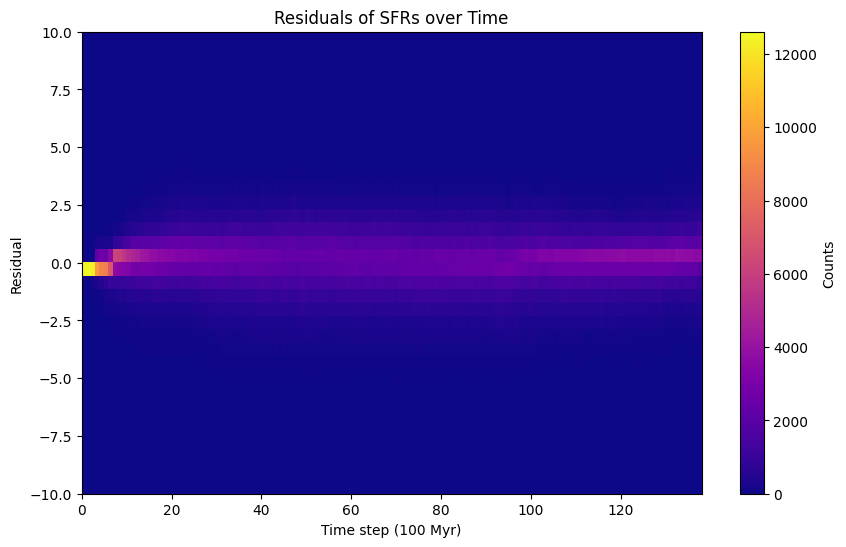

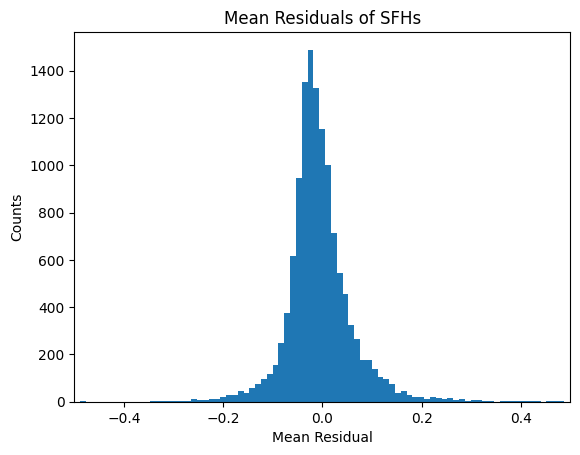

In [206]:
real_SFHs = SFH_test_tensor.unsqueeze(1).to(device)
# Calculate residuals
residuals = (pred_sfh - real_SFHs).detach().cpu().numpy().squeeze()

# Create time axis
time_axis = np.tile(np.arange(residuals.shape[1]), residuals.shape[0])

# Flatten the residuals
residuals_flat = residuals.flatten()

# Create a 2D histogram
plt.figure(figsize=(10, 6))
plt.hist2d(time_axis, residuals_flat, bins=[139, 200], cmap='plasma')
plt.ylim(-10,10)
plt.colorbar(label='Counts')
plt.xlabel('Time step (100 Myr)')
plt.ylabel('Residual')
plt.title('Residuals of SFRs over Time')
plt.show()
plt.hist([np.mean(residual) for residual in residuals], bins=150)
plt.xlabel('Mean Residual')
plt.ylabel('Counts')
plt.title('Mean Residuals of SFHs')
plt.xlim(-0.5, 0.5)
plt.show()